# Redes LSTM

In [216]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import RobustScaler
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import optuna

from tensorflow.keras.models     import Sequential
from tensorflow.keras.layers     import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop, Adam

In [217]:
def train_val_test_split(dataframe, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = dataframe.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = dataframe[0:Ntrain]
    val = dataframe[Ntrain:Ntrain+Nval]
    test = dataframe[Ntrain+Nval:]

    return train, val, test

In [218]:
def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado <-- <--- ¡esta parte de la función se ejecuta en este caso!
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        # Entrada al modelo
        X.append(array[i:i+INPUT_LENGTH,0:cols-1])

        # Salida (el índice 1 corresponde a la columna con la variable a predecir)
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    
    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

In [219]:
df = pd.read_csv('../data/processed/processed_data_energy.csv')

In [208]:
df.insert(0, 'fecha', pd.date_range('2007-01-01 00:00:00', periods = df.shape[0], freq='h'))

In [220]:
df.drop(columns = ['hora', 'dia', 'mes', 'anio'], inplace = True)

In [221]:
tr, vl, ts = train_val_test_split(df, tr_size=0.8, vl_size=0.1, ts_size=0.1 )

In [229]:
tr

,tmax-cab,tmax-hmo,tmax-obr,tmax-lmo,tmax-cul,tmin-cab,tmin-hmo,tmin-obr,tmin-lmo,tmin-cul,...,martes_postfestivo,semana_santa,1_mayo,10_mayo,16_sep,2_nov.,pre-navidad_y_new_year,navidad_y_new_year,post-navidad_y_new_year,demanda_energia
0,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1394
1,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1297
2,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1255
3,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1222
4,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107726,27.0,31.0,29.0,26.0,30.0,10.0,15.0,14.0,16.5,17.0,...,0,1,0,0,0,0,0,0,0,2625
107727,27.0,31.0,29.0,26.0,30.0,10.0,15.0,14.0,16.5,17.0,...,0,1,0,0,0,0,0,0,0,2672
107728,27.0,31.0,29.0,26.0,30.0,10.0,15.0,14.0,16.5,17.0,...,0,1,0,0,0,0,0,0,0,2692
107729,27.0,31.0,29.0,26.0,30.0,10.0,15.0,14.0,16.5,17.0,...,0,1,0,0,0,0,0,0,0,2677


In [222]:
# Definición de los hiperparámetros INPUT_LENGTH y OUTPUT_LENGTH
INPUT_LENGTH = 12     # Registros de 24 horas consecutivas a la entrada 
OUTPUT_LENGTH = 5    # El modelo va a predecir 4 hora a futuro

# Datasets supervisados para entrenamiento (x_tr, y_tr), validación
# (x_vl, y_vl) y prueba (x_ts, y_ts)
x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

In [223]:
df.head(7)

,tmax-cab,tmax-hmo,tmax-obr,tmax-lmo,tmax-cul,tmin-cab,tmin-hmo,tmin-obr,tmin-lmo,tmin-cul,...,martes_postfestivo,semana_santa,1_mayo,10_mayo,16_sep,2_nov.,pre-navidad_y_new_year,navidad_y_new_year,post-navidad_y_new_year,demanda_energia
0,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1394
1,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1297
2,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1255
3,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1222
4,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1168
5,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1128
6,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1100


In [224]:
x_tr

array([[[21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
        [21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
        [21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
        ...,
        [21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
        [21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
        [21. , 22. , 25. , ...,  0. ,  1. ,  0. ]],

       [[21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
        [21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
        [21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
        ...,
        [21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
        [21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
        [21. , 22. , 25. , ...,  0. ,  1. ,  0. ]],

       [[21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
        [21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
        [21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
        ...,
        [21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
        [21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
        [21. , 22. , 25. , ...,  0. ,  1. ,  0. ]],

       ...,

       [[26. , 33.5, 31.

In [225]:
y_tr

array([[[1079.],
        [1086.],
        [1083.],
        [1073.],
        [1067.]],

       [[1086.],
        [1083.],
        [1073.],
        [1067.],
        [1058.]],

       [[1083.],
        [1073.],
        [1067.],
        [1058.],
        [1072.]],

       ...,

       [[2504.],
        [2581.],
        [2621.],
        [2625.],
        [2672.]],

       [[2581.],
        [2621.],
        [2625.],
        [2672.],
        [2692.]],

       [[2621.],
        [2625.],
        [2672.],
        [2692.],
        [2677.]]])

In [226]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input, col_ref):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    - col_ref: parámetro adicional para especificar la columna que contiene
      la variable a predecir

    
    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    # *** Implementación adicional: determinar el índice de la columna
    # que contiene la variable a predecir
    col_ref = df.columns.get_loc(col_ref)

    # Número de instantes de tiempo de entrada y de covariables
    NFEATS = data_input['x_tr'].shape[2]
    print("NFEATS=",NFEATS)

    # Generar listado con "scalers" (1 por cada covariable de entrada)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])
    
    # Escalamiento Ys (teniendo en cuenta "col_ind")
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[col_ref].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[col_ref]

In [228]:
data_in

{'x_tr': array([[[21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
         [21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
         [21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
         ...,
         [21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
         [21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
         [21. , 22. , 25. , ...,  0. ,  1. ,  0. ]],
 
        [[21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
         [21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
         [21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
         ...,
         [21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
         [21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
         [21. , 22. , 25. , ...,  0. ,  1. ,  0. ]],
 
        [[21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
         [21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
         [21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
         ...,
         [21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
         [21. , 22. , 25. , ...,  0. ,  1. ,  0. ],
         [21. , 22. , 25. , ...,  0. ,  1. ,  0. ]],
 
     

In [227]:
# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = 'demanda_energia' )

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

NFEATS= 24


IndexError: list index out of range

In [118]:
data_in

{'x_tr': array([[[2.007e+03, 2.100e+01, 2.200e+01, ..., 1.000e+00, 0.000e+00,
          1.394e+03],
         [2.007e+03, 2.100e+01, 2.200e+01, ..., 1.000e+00, 0.000e+00,
          1.297e+03],
         [2.007e+03, 2.100e+01, 2.200e+01, ..., 1.000e+00, 0.000e+00,
          1.255e+03],
         ...,
         [2.007e+03, 2.100e+01, 2.200e+01, ..., 1.000e+00, 0.000e+00,
          1.022e+03],
         [2.007e+03, 2.100e+01, 2.200e+01, ..., 1.000e+00, 0.000e+00,
          1.029e+03],
         [2.007e+03, 2.100e+01, 2.200e+01, ..., 1.000e+00, 0.000e+00,
          1.055e+03]],
 
        [[2.007e+03, 2.100e+01, 2.200e+01, ..., 1.000e+00, 0.000e+00,
          1.297e+03],
         [2.007e+03, 2.100e+01, 2.200e+01, ..., 1.000e+00, 0.000e+00,
          1.255e+03],
         [2.007e+03, 2.100e+01, 2.200e+01, ..., 1.000e+00, 0.000e+00,
          1.222e+03],
         ...,
         [2.007e+03, 2.100e+01, 2.200e+01, ..., 1.000e+00, 0.000e+00,
          1.029e+03],
         [2.007e+03, 2.100e+01, 2.200e+01

In [101]:
# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celda de memoria (c)   #  <----- hiperparámetro
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 24 (horas) x 14 (feature)   

In [102]:
modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [104]:
optimizador = Adam() #  <----- hiperparámetro
modelo.compile(
    optimizer = optimizador,
    loss = tf.keras.losses.MeanAbsolutePercentageError()
)

In [105]:
EPOCHS = 50 # Hiperparámetro
BATCH_SIZE = 256 # Hiperparámetro

%time historia = modelo.fit( x = x_tr_s, y = y_tr_s,   batch_size = BATCH_SIZE,  epochs = EPOCHS,   validation_data = (x_vl_s, y_vl_s),     verbose=1 )

Epoch 1/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 44392.9102 - val_loss: 361316.0312
Epoch 2/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 22403.1016 - val_loss: 212143.0625
Epoch 3/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 9696.2227 - val_loss: 48663.4062
Epoch 4/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 5567.3281 - val_loss: 111533.4609
Epoch 5/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 5480.5366 - val_loss: 45403.4141
Epoch 6/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 3152.9885 - val_loss: 26458.2129
Epoch 7/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 2729.6538 - val_loss: 39268.7773
Epoch 8/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 2707.6326 - val_loss: 34807.7812
Epoch 9/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 1891.6841 - val_loss: 38494.9688
Epoch 10/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 1689.4893 - val_loss: 73055.0312
Epoch 11/50
421/421 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step

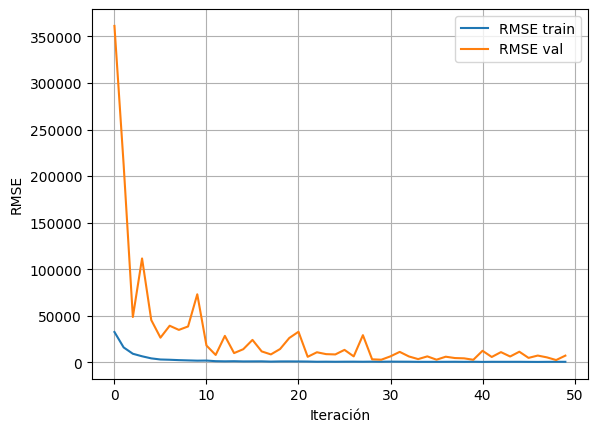

In [106]:
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.grid('True')
plt.legend()

In [107]:
# Cálculo de rmses para train, val y test
mse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
mse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
mse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  MSE train:\t {mse_tr:.3f}')
print(f'  MSE val:\t  {mse_vl:.3f}')
print(f'  MSE test:\t {mse_ts:.3f}')

Comparativo desempeños:
  MSE train:	 554.553
  MSE val:	  7212.204
  MSE test:	 34667.676


In [91]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)
    
    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [108]:
# 1. Generar las predicciones sobre el set de prueba
y_ts_pred_s = modelo.predict(x_ts_s, verbose=0)

# 2. Realizar la transformación inversa de las predicciones para llevar sus
# valores a la escala original
y_ts_pred = scaler.inverse_transform(y_ts_pred_s)

# 3. Calcular RMSE para cada instante de tiempo predicho
diff_cuad = np.square(y_ts.squeeze()-y_ts_pred) # 4995x4

proms = np.mean(diff_cuad, axis=0) # 1x4
rmse = np.sqrt(proms) # 1x4
maximo = np.max(rmse)
print(maximo)

4.634217324455609


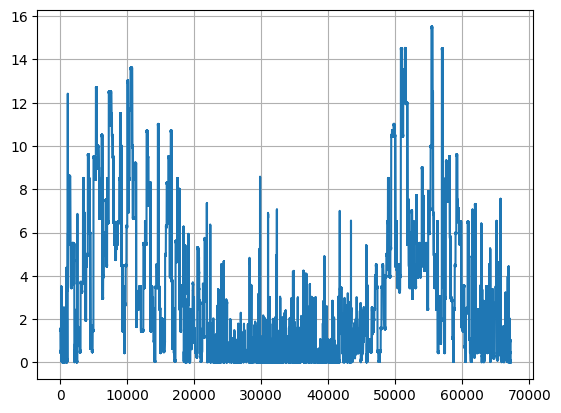

In [115]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = np.abs(y_ts.flatten()-y_ts_pred.flatten())
minimo = np.min(errores)
maximo = np.max(errores)
error_promedio = np.mean(errores)
plt.plot(errores);
plt.grid('True')

In [116]:
print(f'El error máximo fue {maximo}')
print(f'El error mínimo fue {minimo}')
print(f'El error máximo fue {error_promedio}')

El error máximo fue 15.524707794189453
El error mínimo fue 1.52587890625e-05
El error máximo fue 3.003458184837143


In [114]:
y_ts_pred.flatten()

array([29.530079, 29.459833, 29.449991, ..., 33.970413, 33.957924,
       33.903362], dtype=float32)